# **Imports**

In [705]:
import pandas as pd
#import ydata_profiling as pp
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from pywaffle import waffle
import numpy as np
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time

# **Problem**
Predict the average price of apples for the following week

In [706]:
file = 'apples.csv'
df = pd.read_csv(file)
df.dtypes

Unnamed: 0         int64
date              object
average_price    float64
total_volume       int64
gala               int64
fuji               int64
granny_smith       int64
total_bags         int64
s_bags             int64
l_bags             int64
xl_bags            int64
type              object
region            object
dtype: object

# **1. Pre-process**

Working only with region TotalUS due to granularity 

In [707]:
##Pre-pre-process

#Removing what is not TotalUS
df = df[df['region'] == 'TotalUS'].copy()

#Casting date as datetime type
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

#Separating by conventional and organic
df_conv = df[df['type'] == 'conventional']
df_org = df[df['type'] == 'organic']

#Choosing columns of interest
columns_of_interest = ['date', 'average_price', 'total_volume', 'gala', 'fuji', 'granny_smith', 'total_bags', 's_bags', 'l_bags', 'xl_bags']
df_conv = df_conv[columns_of_interest]
df_org = df_org[columns_of_interest]
columns_of_interest.append('type')
df = df[columns_of_interest]

In [708]:
#Calender features
def calender_features(data):
    data['week'] = data['date'].dt.isocalendar().week
    data['week'] = data['week'].astype('int32')
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

calender_features(df), calender_features(df_conv), calender_features(df_org)

(None, None, None)

# **2.Exploratory data-analysis**

In [709]:
#Seaborn styles
sns.set_theme()
sns.set(style="whitegrid")
sns.set_palette("Set2")
plt.style.use('seaborn-v0_8')

Data distribution by year

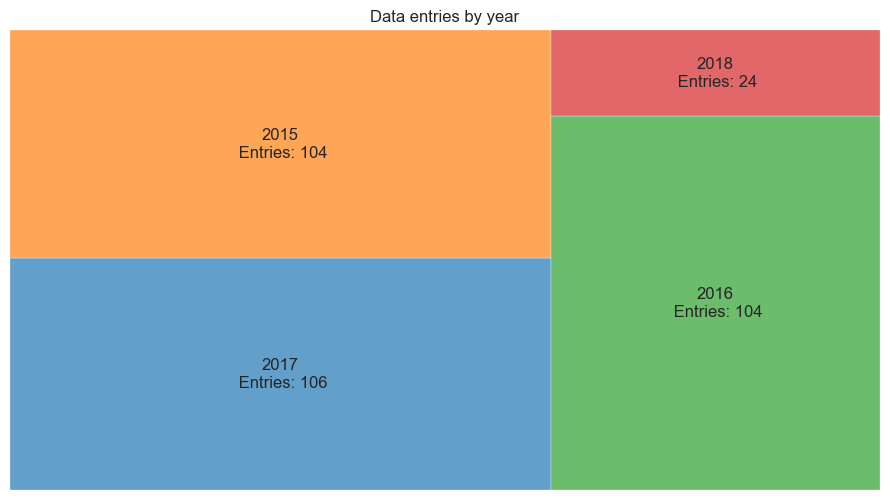

In [710]:
year_count = df["year"].value_counts()
labels = [f"{year}\n Entries: {count}" for year, count in zip(year_count.index, year_count.values)]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

plt.figure(figsize=(10, 5))
plt.title("Data entries by year")

# Passe as cores personalizadas para a função squarify.plot
squarify.plot(sizes=year_count.values, label=labels, alpha=0.7, color=colors)

plt.axis('off')  # Remove os eixos
plt.show()

2018 has less data, we don't have the hole year

2016 and 2015 have 52 weeks each (double the data because we're dealing with two types)

2017 has 53 weeks? -> analyze that

Volume analysis

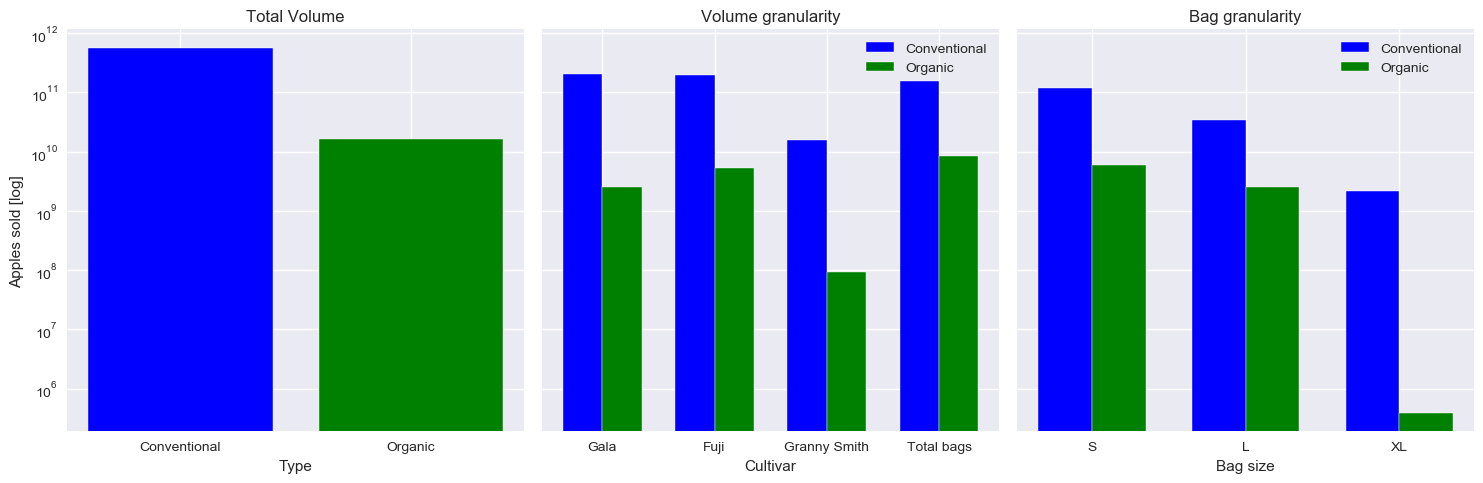

In [711]:
type = df['type'].unique()
cultivar = ['Gala', 'Fuji', 'Granny Smith', 'Total bags']
bag_size = ['S', 'L', 'XL']
values_1 = [df_conv['total_volume'].sum(), df_org['total_volume'].sum()]
values_2_group_1 = [df_conv['gala'].sum(), df_conv['fuji'].sum(), df_conv['granny_smith'].sum(), df_conv['total_bags'].sum()]
values_2_group_2 = [df_org['gala'].sum(), df_org['fuji'].sum(), df_org['granny_smith'].sum(), df_org['total_bags'].sum()]
values_3_group_1 = [df_conv['s_bags'].sum(), df_conv['l_bags'].sum(), df_conv['xl_bags'].sum()]
values_3_group_2 = [df_org['s_bags'].sum(), df_org['l_bags'].sum(), df_org['xl_bags'].sum()]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
colors = ['blue', 'green']
label = ['Conventional', 'Organic']
# First histogram (Normal bar chart)
axs[0].bar(label, values_1, color=colors)#, bar_width=0.35)
axs[0].set_xlabel('Type')
axs[0].set_ylabel('Apples sold [log]')
axs[0].set_title('Total Volume')
axs[0].set_yscale('log')

# Second histogram (Grouped bar chart)
bar_width = 0.35
index = np.arange(len(cultivar))
axs[1].bar(index, values_2_group_1, bar_width, label=label[0], color=colors[0], align='center')
axs[1].bar(index + bar_width, values_2_group_2, bar_width, label=label[1], color=colors[1], align='center')
axs[1].set_xlabel('Cultivar')
axs[1].set_title('Volume granularity')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(cultivar)
axs[1].legend()
axs[1].set_yscale('log')

# Third histogram (Grouped bar chart)
index = np.arange(len(bag_size))
axs[2].bar(index, values_3_group_1, bar_width, label=label[0], color=colors[0], align='center')
axs[2].bar(index + bar_width, values_3_group_2, bar_width, label=label[1], color=colors[1], align='center')
axs[2].set_xlabel('Bag size')
axs[2].set_title('Bag granularity')
axs[2].set_xticks(index + bar_width / 2)
axs[2].set_xticklabels(bag_size)
axs[2].legend()
axs[2].set_yscale('log')

plt.tight_layout()

Price and volume analysis

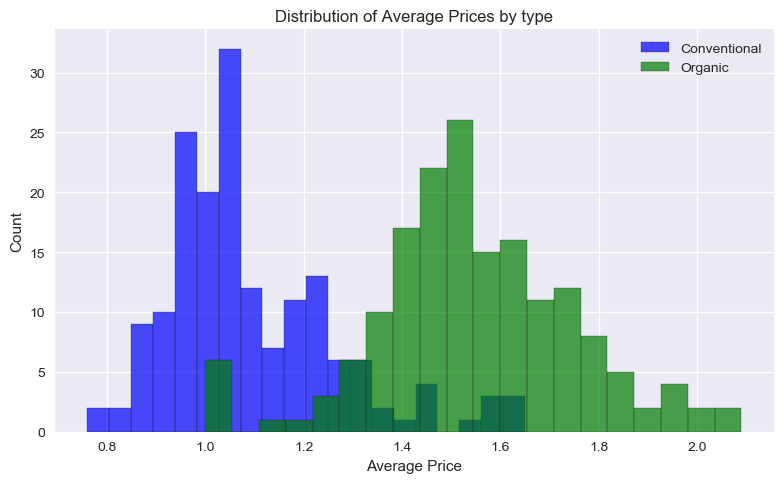

In [712]:
conventional_data = df[df["type"] == "conventional"]
organic_data = df[df["type"] == "organic"]

plt.figure(figsize=(8, 5))

plt.hist(conventional_data["average_price"], bins=20, edgecolor='k', alpha=0.7, color='blue', label ='Conventional')

plt.hist(organic_data["average_price"], bins=20, edgecolor='k', alpha=0.7, color='green', label = 'Organic')
plt.title("Distribution of Average Prices by type")
plt.xlabel("Average Price")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

plt.tight_layout() 

1.65
0.76
2.09
1.0


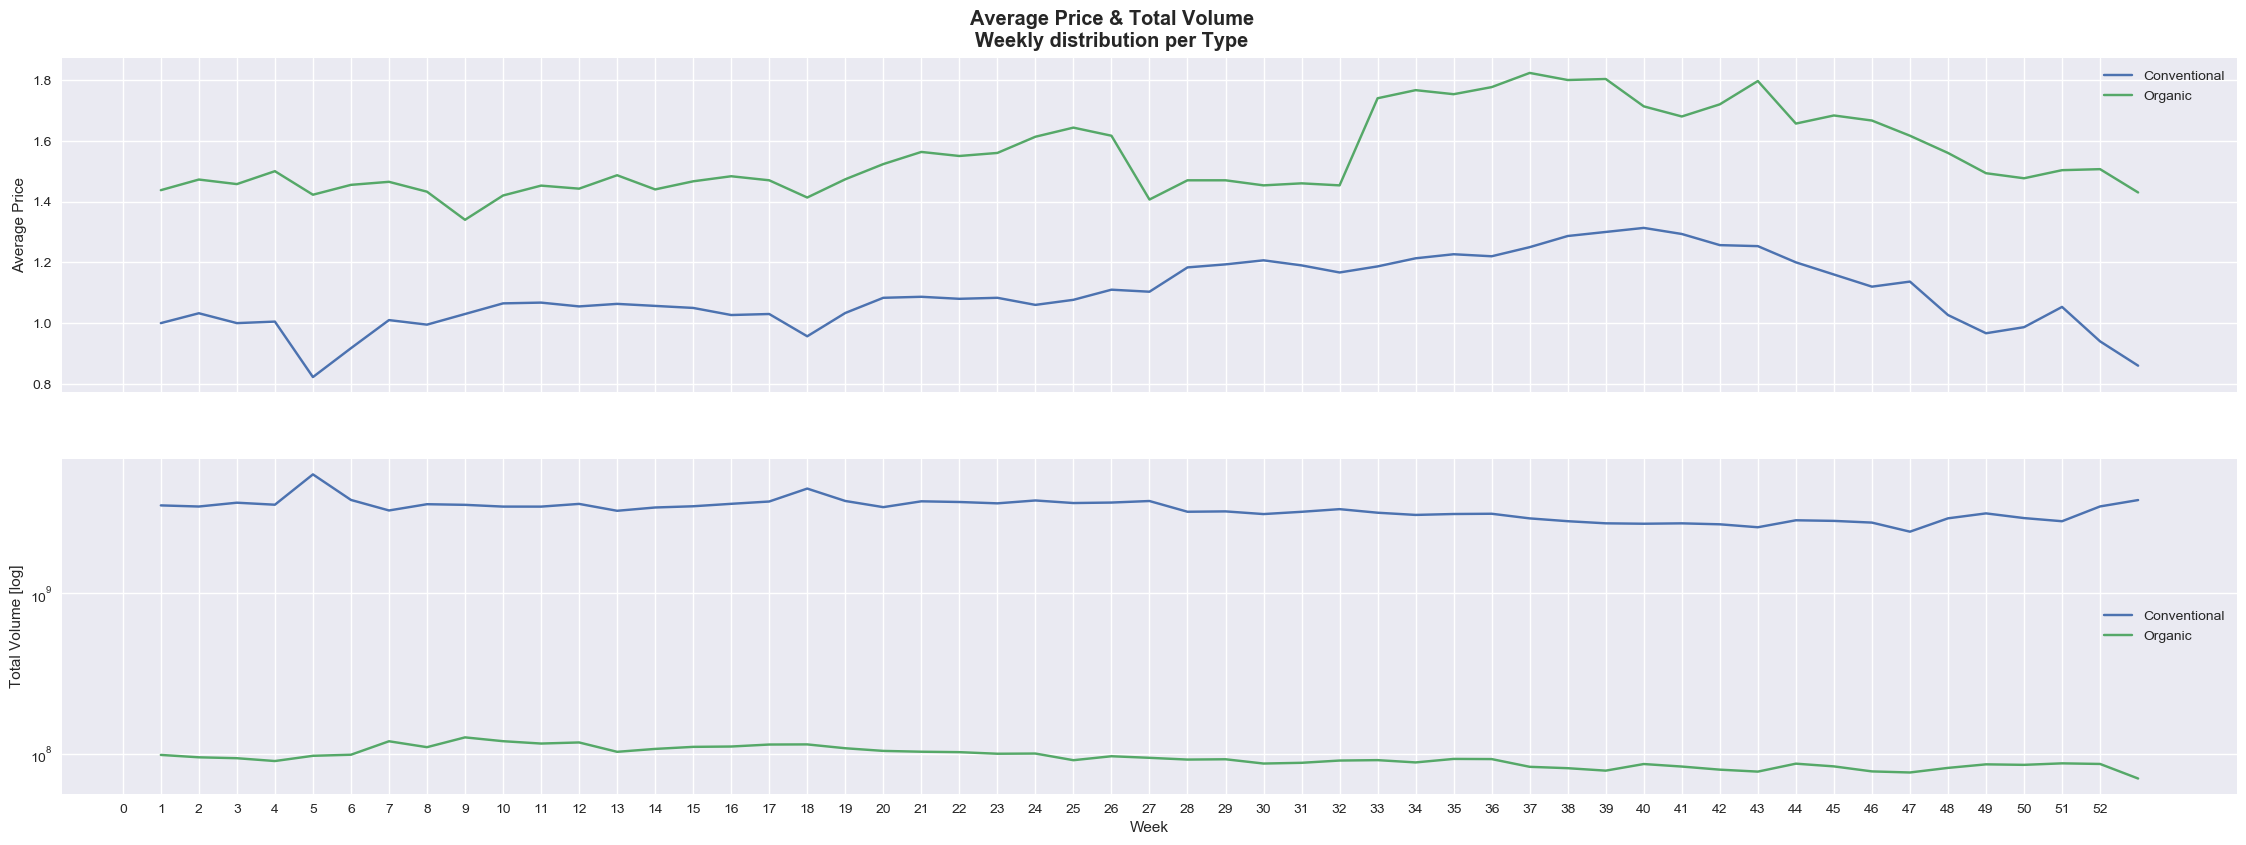

In [713]:
from brokenaxes import brokenaxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, ax = plt.subplots(2,1,figsize=(25,8))
figure.suptitle("Average Price & Total Volume\nWeekly distribution per Type", y=1.05, fontweight='bold')
listOf_Xticks = np.arange(0, 53, 1)
plt.xticks(listOf_Xticks)
plt.xlabel("Week")
ax[0].set_ylabel("Average Price")
ax[1].set_ylabel("Total Volume [log]")

df_avg_price_conv_week = df_conv['average_price'].groupby(df_conv['week']).mean()
df_avg_price_org_week =  df_org['average_price'].groupby(df_org['week']).mean()
df_volume_conv_week = df_conv['total_volume'].groupby(df_conv['week']).mean()
df_volume_org_week =  df_org['total_volume'].groupby(df_org['week']).mean()

ax[0].plot(df_avg_price_conv_week, label="Conventional")
ax[0].plot(df_avg_price_org_week, label="Organic")
ax[0].set_xticks(listOf_Xticks)
ax[0].set_xticklabels([])
ax[0].legend()

ax[1].plot(df_volume_conv_week, label="Conventional")
ax[1].plot(df_volume_org_week, label="Organic")
ax[1].set_yscale('log')
ax[1].legend()

print(df_conv['average_price'].max())
print(df_conv['average_price'].min())
print(df_org['average_price'].max())
print(df_org['average_price'].min())

Monthly average prices

In [714]:
def groupby_month(d): #Group by month and average the price
    d_new = d.groupby('month')['average_price'].mean().reset_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    d_new['month'] = d_new['month'].apply(lambda x: months[x - 1])
    return d_new #Returns list of average prices for each month

def grafico_fixe(d): #escolham um melhor nome pls
    years = d['year'].unique()
    for year in years:
        provisoria = groupby_month(d[d['year']==year])
        sns.scatterplot(x=provisoria['month'], y=provisoria['average_price'], label=year)
        plt.plot(provisoria['month'], provisoria['average_price'])

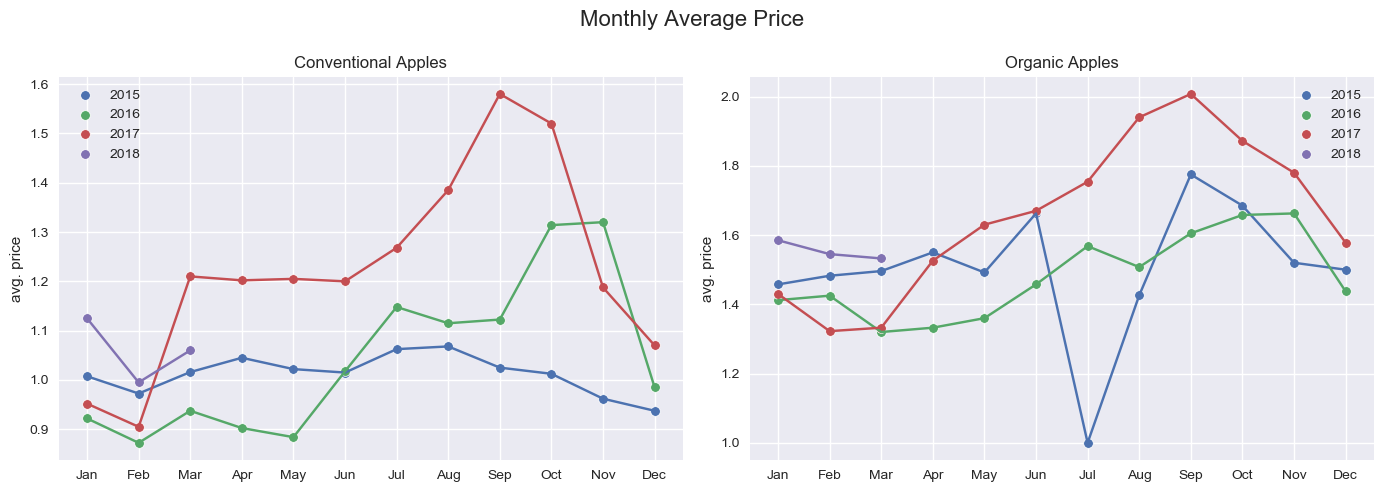

In [715]:
plt.figure(figsize=(14, 5))
plt.suptitle('Monthly Average Price', fontsize=16)

plt.subplot(1, 2, 1) #1st plot
grafico_fixe(df_conv)
plt.xlabel('')
plt.ylabel('avg. price')
plt.title('Conventional Apples')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2) #2nd plot
grafico_fixe(df_org)
plt.xlabel('')
plt.ylabel('avg. price')
plt.title('Organic Apples')
plt.legend()
plt.tight_layout()

That dip on organic prices (jul-2015) needs to be solved! 

# **3. Models**

In [716]:
df_conv['target'] = df_conv['average_price'].shift(-1)
df_conv = df_conv.loc[df_conv['target'].notna()].copy().reset_index(drop = True)

split_date = pd.to_datetime('2018-01-01')

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

def print_stats(df_set, df):
    print(f'Percentage of original: {len(df_set) / len(df):.0%}')
    print('Target min: {}'.format(df_set["target"].min()))
    print(f'Target median:\t{df_set["target"].median():,.2f}')
    print(f'Target mean:\t{df_set["target"].mean():,.2f}')
    print(f'Target max:\t{df_set["target"].max():,.2f}')

print('\nFull train')
print_stats(df_conv_train, df_conv)
print('\nTest')
print_stats(df_conv_test, df_conv)


Full train
Percentage of original: 93%
Target min: 0.76
Target median:	1.04
Target mean:	1.10
Target max:	1.65

Test
Percentage of original: 7%
Target min: 0.87
Target median:	1.07
Target mean:	1.05
Target max:	1.20


3.1 Baseline: xgboost gradient boost regression

In [717]:
from xgboost import XGBRegressor

#Hyper-parameters
algo_params = {
    'max_depth': 2, #tree-depth
    'n_estimators': 10, #number of trees
}
algo_params['seed'] = 123 
algo_params['n_jobs'] = -1 #PC config to use all local clusters
algo_params['tree_method'] = 'hist' #histogram-based method for faster training
algo_params['use_label_encoder'] = False #No label encoding for categorical features

#Create instance of regression model with the params
model = XGBRegressor(**algo_params)  #**: dic key-value pairs as keyword args to the constructor 
                                     #-> same thing as explicitly writing each h-param in the function

#### features used
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
]

model.fit( #Training the model
    df_conv_train[numeric_features_used],
    df_conv_train['target']
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

Evaluating the model

In [718]:
from sklearn.metrics import mean_squared_error

def print_score(model, train, test, features):
    preds_train = model.predict(train[features])
    rmse_train = mean_squared_error(train['target'], preds_train, squared = False)

    preds_test = model.predict(test[features])
    rmse_test = mean_squared_error(test['target'], preds_test, squared = False)

    overfit = rmse_test - rmse_train

    print(f'Train score: {rmse_train:,.5f}')
    print(f'Test score: {rmse_test:,.5f} \t||\t Overfit: {overfit:,.5f} \t||\t Relative overfit: {overfit/rmse_test*100:,.1f}%\n')
    
print_score(model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.05723
Test score: 0.07134 	||	 Overfit: 0.01411 	||	 Relative overfit: 19.8%



In [719]:
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,average_price,0.736666
4,granny_smith,0.098607
1,total_volume,0.088559
8,xl_bags,0.056487
6,s_bags,0.014243
3,fuji,0.005438
2,gala,0.000000
5,total_bags,0.000000
7,l_bags,0.000000


3.2 Feature Engineering

In [720]:
#Moving average and STD for average_price
month_size = 4
df_conv['RM_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).mean()
df_conv['STD_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).std()

#Price elasticity: measure of how price increase affects volume
df_conv['price_elasticity'] = (df_conv['total_volume'].pct_change())/(df_conv['average_price'].pct_change())

numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'month',
    'year',
    'price_elasticity'
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)


xgboost gradient boost regression with grid search

In [721]:
#Finding the best h-params for Xgboost model by grid search and cross-validation (TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

# basic config to be used in all combinations
algo_params['seed'] = 123
algo_params['n_jobs'] = -1
algo_params['tree_method'] = 'hist'
algo_params['use_label_encoder'] = False

#core model
model = XGBRegressor(**algo_params)

#target transformer
target_scale = MinMaxScaler(feature_range = (1, 10000))
target_norm = QuantileTransformer(
    n_quantiles = 100,
    output_distribution = 'normal',
    random_state = 123
)
target_norm = Pipeline([('min', target_scale), ('quantile', target_norm)])

#model inside a pipeline
model = TransformedTargetRegressor(regressor = model, transformer = target_norm)

# params to search for
parameters = {
    'regressor__n_estimators': [8, 10, 12], # 
    'regressor__max_depth': [2, 3, 4],
}

cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

#Trains the model on different combinations of h-params
#Evaluates performance with cv amd chooses the best combination
grid = GridSearchCV(
    estimator = model,
    param_grid = parameters,
    cv = cv_splitter,
    n_jobs = -1,
    refit = True,
)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=TransformedTargetRegressor(regressor=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         gamma=...
                                                                         n_estimators=10,
                                                                         n_jobs=-1,
                                                                         num_parallel_tree=None,
                                                                         predictor=None,
                                                                         random_state=None, ...),
                                                  transformer=Pipeline(steps=[('min',
                                                                               MinMaxScaler(feature_range=(1,
                                                                                                           10000))),
                                                                              ('quantile',
                                                                               QuantileTransformer(n_quantiles=100,
                                                                                                   output_distribution='normal',
                                                                                                   random_state=123))])),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [2, 3, 4],
                         'regressor__n_estimators': [8, 10, 12]})

In [722]:
#pd.DataFrame(grid.cv_results_)
best_model = grid.best_estimator_

print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.04152
Test score: 0.09842 	||	 Overfit: 0.05690 	||	 Relative overfit: 57.8%



In [723]:
feature_importances = best_model.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,average_price,0.395100
9,RM_avgP_M,0.231606
10,STD_avgP_M,0.078387
11,week,0.049163
4,granny_smith,0.047617
6,s_bags,0.035231
8,xl_bags,0.031287
2,gala,0.030698
13,year,0.027604
5,total_bags,0.020225


The feature importance of average price demisnished significantly. The montly moving average seems to have significant importance. Each of the features has a small impact on the model by themselves, but a larger combined importance.

Error Analyses

In [727]:
def error_analysis(df_test, features, model):
    df_error = df_test.copy()

    df_error['prediction'] = model.predict(df_error[features])

    df_error['error'] = df_error['prediction'] - df_error['target']
    df_error['abs_error'] = df_error['error'].abs()
    n_bins = 4
    df_error['error_bin'] = pd.cut(df_error['abs_error'], n_bins).apply(lambda x: x.mid).astype('float')

    #df_error.tail(5)

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # First subplot
    axs[0, 0].scatter(df_error['target'], df_error['error'])
    axs[0, 0].set_xlabel('Target')
    axs[0, 0].set_ylabel('Error = Prediction - Target')
    axs[0, 0].set_title('Real Error')

    # Second subplot
    axs[0, 1].scatter(df_error['target'], df_error['abs_error'])
    axs[0, 1].set_xlabel('Target')
    axs[0, 1].set_ylabel('|Error|')
    axs[0, 1].set_title('Absolute Error')

    # Third subplot
    axs[1, 0].scatter(df_error['target'], df_error['error_bin'])
    axs[1, 0].set_xlabel('Target')
    axs[1, 0].set_ylabel('Error by bin')
    axs[1, 0].set_title('Error Bin ({} bins)'.format(n_bins))

    # Fourth subplot
    df_error['abs_error'].plot(ax=axs[1, 1])
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('|Error|')
    axs[1, 1].set_title('Absolute Error')

    # Adjust layout
    plt.tight_layout()

The value of the errors are very similar to each other, except for one value, due to being an anomaly low target

More feature engineering

In [732]:
#Previous week
df_conv['week_prev'] = df_conv['week'].shift(1) #All correct except the first
df_conv.at[0, 'week_prev'] = 52
df_conv['week_prev'] = df_conv['week_prev'].astype('int32')

#Previous month
df_conv['month_prev'] = df_conv['date'].dt.month -1
df_conv.loc[df_conv['month_prev'] == 0, 'month_prev'] = 12

#Reordering columns
df_conv = df_conv[["date", "average_price", "total_volume", "gala", "fuji", "granny_smith", "total_bags", "s_bags", "l_bags", "xl_bags", "year", "target", "RM_avgP_M", "STD_avgP_M", "price_elasticity", "week", "week_prev", "month", "month_prev"]]

#Two extra moving averages due to the importance of the monthly moving average
alpha = 2/(month_size+1)
df_conv['EMA_avgP_M'] = df_conv['average_price'].ewm(span=month_size, adjust=False).mean() #exponentional moving average
quatrer_size = 13
df_conv['RM_avgP_Q'] = df_conv['average_price'].rolling(window=quatrer_size, min_periods=0).mean()
df_conv['STD_avgP_Q'] = df_conv['average_price'].rolling(window=quatrer_size, min_periods=0).std()
lag = 4
df_conv['Lag_Price'] = df_conv['average_price'].shift(lag)



C:\Users\TomásAlmeida\AppData\Local\Temp\ipykernel_10860\2119846730.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TomásAlmeida\AppData\Local\Temp\ipykernel_10860\2119846730.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [733]:
df_conv

,date,average_price,total_volume,gala,fuji,granny_smith,total_bags,s_bags,l_bags,xl_bags,...,STD_avgP_M,price_elasticity,week,week_prev,month,month_prev,EMA_avgP_M,RM_avgP_Q,STD_avgP_Q,Lag_Price
0,2015-01-04,0.95,3132427773,1235716134,1362408305,84409332,449894002,358532158,89494563,1867281,...,NaN,NaN,1,52,1,12,0.950000,0.950000,NaN,NaN
1,2015-01-11,1.01,2906354275,1154481053,1213477338,86657466,451738418,378326116,71833387,1578915,...,0.042426,-1.142723,2,1,1,12,0.974000,0.980000,0.042426,NaN
2,2015-01-18,1.03,2904345885,1185813934,1170194780,83130190,465206981,387304126,77109320,793535,...,0.041633,-0.034897,3,2,1,12,0.996400,0.996667,0.041633,NaN
3,2015-01-25,1.04,2847031084,1216744503,1073465282,76802005,480019294,397863690,81292473,863131,...,0.040311,-2.032618,4,3,1,12,1.013840,1.007500,0.040311,NaN
4,2015-02-01,0.89,4465546151,1893303804,1895647974,138151611,538442762,421645203,112107647,4689912,...,0.069462,-3.941546,5,4,2,1,0.964304,0.984000,0.063087,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2018-02-18,1.08,3670988749,1326275142,1049191844,55296973,1240224790,902335168,315115742,22773880,...,0.103722,-1.319203,7,6,2,1,1.028625,1.077692,0.100594,1.08
164,2018-02-25,1.06,4002152876,1382985787,1041546359,72433016,1505187714,1066694278,408139772,30353664,...,0.096090,-4.871402,8,7,2,1,1.041175,1.063846,0.087990,1.09
165,2018-03-04,1.07,4074121405,1443954746,1128930737,57174772,1444061150,1083290744,333921496,26848910,...,0.050662,1.906140,9,8,3,2,1.052705,1.062308,0.087669,0.87
166,2018-03-11,1.09,4044960312,1408909105,1075803945,70757882,1489489380,1139282889,322955662,27250829,...,0.012910,-0.382934,10,9,3,2,1.067623,1.066923,0.087406,0.97


Repeating the model

In [734]:
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    'price_elasticity',
    'EMA_avgP_M',
    'STD_avgP_Q',
    'RM_avgP_Q',
    'Lag_Price',
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

best_model = grid.best_estimator_

print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.03476
Test score: 0.09196 	||	 Overfit: 0.05719 	||	 Relative overfit: 62.2%



In [735]:
feature_importances = best_model.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,average_price,0.274119
9,RM_avgP_M,0.248574
18,STD_avgP_Q,0.079928
10,STD_avgP_M,0.061040
12,week_prev,0.050799
11,week,0.040094
17,EMA_avgP_M,0.038924
15,year,0.025827
5,total_bags,0.025521
14,month_prev,0.024337


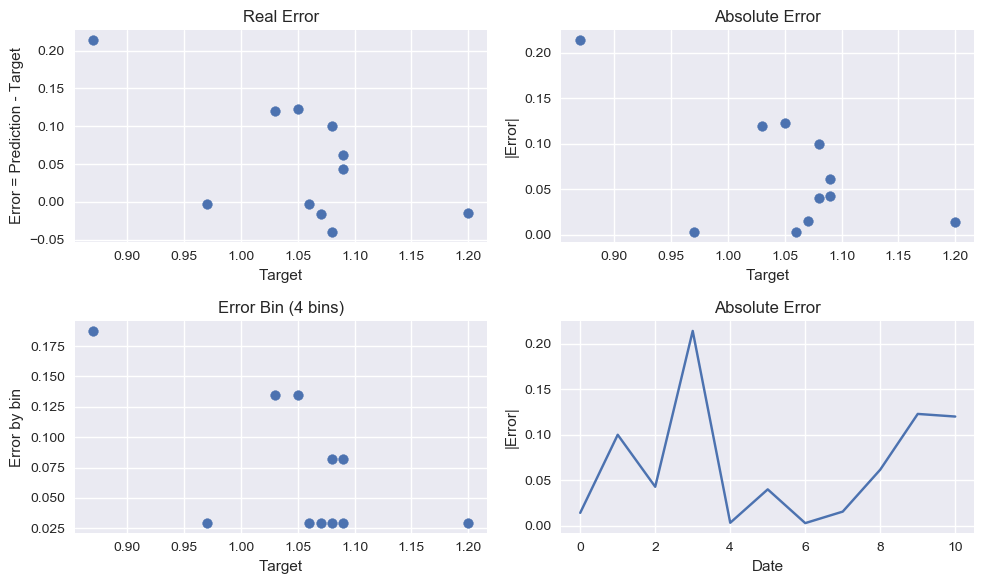

In [736]:
error_analysis(df_conv_test, numeric_features_used, best_model)

Last iteration of gradient boost, with the features that yielded the highest importance

In [737]:
numeric_features_used = [
    'average_price',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'STD_avgP_Q',
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

best_model = grid.best_estimator_

print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.05089
Test score: 0.05768 	||	 Overfit: 0.00679 	||	 Relative overfit: 11.8%



In [740]:
!pip list

Package                       Version
----------------------------- ---------
aiofiles                      22.1.0
aiohttp                       3.8.3
aiosignal                     1.2.0
aiosqlite                     0.18.0
anaconda-anon-usage           0.3.0
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.3
anaconda-project              0.11.1
annotated-types               0.5.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
async-timeout                 4.0.2
attrs                         22.1.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
beautifulsoup4                4.12.2
bleach                        4.1.0
boltons                       23.0.0
Bottleneck

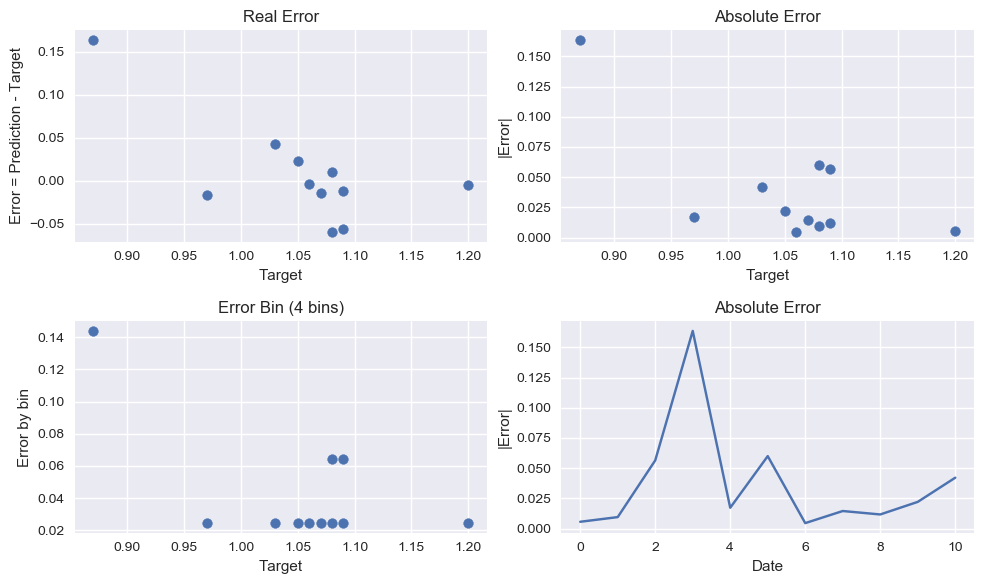

In [739]:
error_analysis(df_conv_test, numeric_features_used, best_model)

Preparing data to use on RF

In [57]:
#Separating target
df_convY = df_conv_train['target']
df_convY.head()

numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

#Data to use 
df_convX = df_conv_train[numeric_features_used]


In [59]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [60]:
train_X, test_X, train_Y, test_Y = train_test_split(df_convX, df_convY, test_size=0.2, shuffle=False)
train_X = train_X.values
train_Y = train_Y.values

In [61]:
train_X, test_X, train_Y, test_Y = train_test_split(df_convX, df_convY, test_size=0.2, shuffle=False)
train_X = train_X.values
train_Y = train_Y.values

train_X, test_X = df_conv_train[numeric_features_used], df_conv_test[numeric_features_used]
train_Y, test_Y = df_conv_train['target'], df_conv_test['target']

tuned_parameters = {
 'n_estimators': [500, 700, 1000],
 'max_depth': [ 1, 2, 3],
 'min_samples_split': [0.2, 0.5, 0.8]
}

GSDTR = GridSearchCV(
   ensemble.RandomForestRegressor(),
   tuned_parameters,
   cv=5,
   scoring=["r2","neg_mean_squared_error"],
   n_jobs=-1,
   verbose=4,
   refit = False
)

DTR_result = GSDTR.fit(train_X,train_Y)
best_score = DTR_result.best_score_
#print(DTR_result.best_estimator_.get_params())


Fitting 5 folds for each of 27 candidates, totalling 135 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters
tuned_parameters = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [1, 2, 3],
    'min_samples_split': [0.2, 0.5, 0.8]
}

# RandomForestRegressor
RF = RandomForestRegressor()

# Search for the hyperparameters
GSRF = GridSearchCV(RF, tuned_parameters, cv=5)  

# Model Adjustment
RF_result = GSRF.fit(train_X, train_Y)

# Best hyperparameters
best_params = RF_result.best_params_
print("Best hyperparameters found :", best_params)

# Best Score
best_score = RF_result.best_score_
print("Best result found:", best_score)

KeyboardInterrupt: 

In [ ]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

def best_model(modelos, train, test, features):
    for model in modelos:
        model.fit(train[features], train['target'])
        print(model)
        print_score(model, train, test, numeric_features_used)

best_model(regressors, df_conv_train, df_conv_test, numeric_features_used)

KNeighborsRegressor()
Train score: 0.10306
Test score: 0.07763 	||	 Overfit: -0.02542 	||	 Relative overfit: -32.7%

GradientBoostingRegressor()
Train score: 0.01347
Test score: 0.09352 	||	 Overfit: 0.08005 	||	 Relative overfit: 85.6%

KNeighborsRegressor()
Train score: 0.10306
Test score: 0.07763 	||	 Overfit: -0.02542 	||	 Relative overfit: -32.7%

ExtraTreesRegressor()
Train score: 0.00000
Test score: 0.10344 	||	 Overfit: 0.10344 	||	 Relative overfit: 100.0%

RandomForestRegressor()
Train score: 0.02538
Test score: 0.10003 	||	 Overfit: 0.07465 	||	 Relative overfit: 74.6%

DecisionTreeRegressor()
Train score: 0.00000
Test score: 0.15079 	||	 Overfit: 0.15079 	||	 Relative overfit: 100.0%

LinearRegression()
Train score: 0.05576
Test score: 0.09646 	||	 Overfit: 0.04070 	||	 Relative overfit: 42.2%

Lasso()
Train score: 0.11752
Test score: 0.15124 	||	 Overfit: 0.03372 	||	 Relative overfit: 22.3%

Ridge()
Train score: 0.06891
Test score: 0.12130 	||	 Overfit: 0.05239 	||	 Relat

c:\Users\MarcoCaetano\anaconda3\envs\env_test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 4.988e-04
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 8]
y_pred = [2.5, 0.0, 2, 8]
r2 = r2_score(y_true, y_pred)
print("R²:", r2)


# Define the hyperparameters
tuned_parameters = {
    'n_estimators': [10,15,20,30],
    'max_depth': [1,2,3],
    'min_samples_split': [0.05,0.10, 0.15]
}


# RandomForestRegressor
RF = RandomForestRegressor()

# Search for the hyperparameters
GSRF = GridSearchCV(RF, tuned_parameters, cv=5)  

# Model Adjustment
RF_result = GSRF.fit(train_X, train_Y)

# Best hyperparameters
best_params = RF_result.best_params_
print("Best hyperparameters found :", best_params)

# Best Score
best_score = RF_result.best_score_
print("Best result found:", best_score)

R²: 0.9869067103109657
Best hyperparameters found : {'max_depth': 2, 'min_samples_split': 0.15, 'n_estimators': 15}
Best result found: -0.12274687462180016


<h3> Ridge with grid search </h3>

In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the features you want to use for training
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

# Define the cross-validation strategy
cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

# Create the Ridge model
model = Ridge()

# Define the search space for hyperparameters
search_space_linear = {
    'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Create the GridSearchCV instance
search = GridSearchCV(model, search_space_linear, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv_splitter)

# Fit the search to your training data using the specific features
result = search.fit(df_conv_train[numeric_features_used], df_conv_train['target'])

# Get the best model from the search
best_model = search.best_estimator_

# Now you can print the score or other relevant information
print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)



Train score: 0.05601
Test score: 0.10125 	||	 Overfit: 0.04524 	||	 Relative overfit: 44.7%



<h3> RandomForestRegressor with gridsearch<h3>

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

# Define the features you want to use for training
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

# Define the hyperparameters to search
tuned_parameters = {
    'n_estimators': [10, 15, 20, 30],
    'max_depth': [1, 2, 3],
    'min_samples_split': [0.05, 0.10, 0.15]
}

# Create the RandomForestRegressor model
RF = RandomForestRegressor()

# Use GridSearchCV for hyperparameter tuning
GSRF = GridSearchCV(RF, tuned_parameters, cv=5)

# Fit the model with training data (you may need to adjust the data)
GSRF.fit(df_conv_train[numeric_features_used], df_conv_train['target'])

# Get the best model with optimal hyperparameters
best_model = GSRF.best_estimator_

# Calculate R^2 score on the test data (you may need to adjust the test data)
test_X = df_conv_test[numeric_features_used]
test_Y = df_conv_test['target']
predictions = best_model.predict(test_X)
r2 = r2_score(test_Y, predictions)
print("R^2 score on the test data:", r2)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_Y, predictions)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_Y, predictions)
print("Mean Absolute Error:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)


R^2 score on the test data: -0.5061490998977558
Mean Squared Error: 0.009181285752765165
Mean Absolute Error: 0.06659428901337767
Root Mean Squared Error: 0.09581902604788449


<h3>DecisionTreeRegressor<h3>

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Define as características que você deseja usar
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
]

# Defina X (características) e y (variável de destino)
X = df[numeric_features_used]
y = df['average_price'] 

# Divida os dados em conjuntos de treinamento e teste
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie o modelo de árvore de decisão
model = DecisionTreeRegressor()

# Treine o modelo nos dados de treinamento
model.fit(train_X, train_y)

# Faça previsões nos dados de teste
predictions = model.predict(test_X)

# Calcule o coeficiente de determinação (R²) para avaliar o modelo
r2 = r2_score(test_y, predictions)
print("R² Score:", r2)

# Calcule o erro médio quadrático (MSE)
mse = mean_squared_error(test_y, predictions)
print("Mean Squared Error:", mse)

# Calcule o erro médio absoluto (MAE)
mae = mean_absolute_error(test_y, predictions)
print("Mean Absolute Error:", mae)

# Calcule a raiz do erro médio quadrático (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calcule o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((test_y - predictions) / test_y)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calcule o coeficiente de correlação de Pearson (r)
r = np.corrcoef(test_y, predictions)[0, 1]
print("Pearson Correlation Coefficient (r):", r)

# Calcule o erro quadrático médio percentual (PQME)
pqme = np.mean(((test_y - predictions) / test_y) ** 2) * 100
print("Percentual Quadratic Mean Error (PQME):", pqme)



R² Score: 0.9987747333428281
Mean Squared Error: 0.00010735294117647025
Mean Absolute Error: 0.003970588235294116
Root Mean Squared Error: 0.01036112644341677
Mean Absolute Percentage Error (MAPE): 0.326913990020482
Pearson Correlation Coefficient (r): 0.9994347001257821
Percentual Quadratic Mean Error (PQME): 0.011793286824281157


<h3>xgboost <h3>

In [67]:
# Importe as bibliotecas necessárias
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

# Define as características que você deseja usar
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    #'RM_avgP_M',
    #'week',
    #'month',
    #'year'
]

# Carregue seus dados em um DataFrame do Pandas (substitua 'seu_arquivo.csv' pelo caminho do seu arquivo de dados)
df = pd.read_csv('apples.csv')

# Divida os dados em recursos (X) e rótulos (y)
X = df[numeric_features_used]
y = df['average_price']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie o objeto do modelo XGBoost
model = xgb.XGBRegressor()

# Treine o modelo nos dados de treinamento
model.fit(X_train, y_train)

# Faça previsões nos dados de teste
y_pred = model.predict(X_test)

# Calcule o R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 score on the test data:", r2)

# Calcule o erro médio quadrático (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcule o erro médio absoluto (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calcule a raiz do erro médio quadrático (RMSE)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calcule o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calcule o coeficiente de correlação de Pearson (r)
r = np.corrcoef(y_test, y_pred)[0, 1]
print("Pearson Correlation Coefficient (r):", r)

# Calcule o erro quadrático médio percentual (PQME)
pqme = np.mean(((y_test - y_pred) / y_test) ** 2) * 100
print("Percentual Quadratic Mean Error (PQME):", pqme)



R^2 score on the test data: 0.9999850606134051
Mean Squared Error: 2.400297549524928e-06
Mean Absolute Error: 0.00022677674750759406
Root Mean Squared Error: 0.0015492893692028381
Mean Absolute Percentage Error (MAPE): 0.015272631896234425
Pearson Correlation Coefficient (r): 0.9999926132819464
Percentual Quadratic Mean Error (PQME): 3.533573966842277e-05
